In [7]:
import numpy as np 
import pandas as pd
import os, zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from zipfile import ZipFile
from PIL import Image


from keras.preprocessing.image import load_img, img_to_array
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [12]:
import warnings
warnings.filterwarnings("ignore")

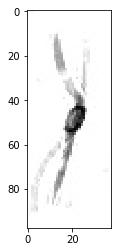

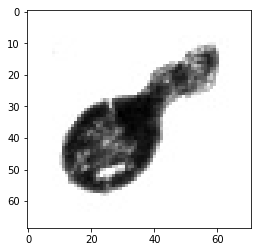

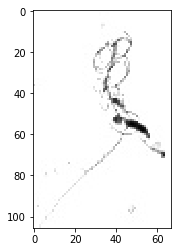

In [18]:
%matplotlib inline
from skimage.io import imread
from IPython import display

'''Christian, just replace make another row of your path 
   where you will unzip the folders and when you push to github
   comment it Like I did'''

path = '/home/aris/Desktop/Data/train_data/0/'

for count,filename in enumerate(os.listdir(path)):
    
    
    plt.figure()
    img=imread(path+filename, as_grey=True)
    plt.imshow(img, cmap='gray')

    #shows only the first three images and after breaks the loop.
    if count ==2:
            break
    


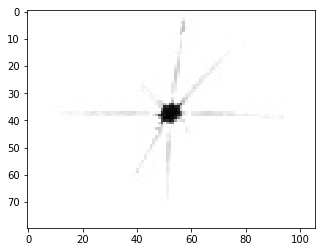

In [21]:
test_image = './train_images/64.jpg'
im = imread(test_image, as_grey=True)
plt.imshow(im, cmap='gray')
plt.show()

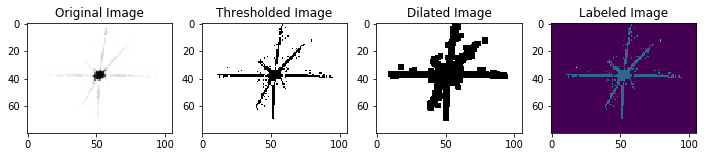

In [25]:
from pylab import cm
from skimage import segmentation
from skimage.morphology import watershed
from skimage import measure
from skimage import morphology

# First we threshold the image by only taking values greater than the mean to reduce noise in the image
# to use later as a mask
f = plt.figure(figsize=(12,3))
imthr = im.copy()
imthr = np.where(im > np.mean(im),0.,1.0)
sub1 = plt.subplot(1,4,1)
plt.imshow(im, cmap=cm.gray)
sub1.set_title("Original Image")

sub2 = plt.subplot(1,4,2)
plt.imshow(imthr, cmap=cm.gray_r)
sub2.set_title("Thresholded Image")

imdilated = morphology.dilation(imthr, np.ones((4,4)))
sub3 = plt.subplot(1, 4, 3)
plt.imshow(imdilated, cmap=cm.gray_r)
sub3.set_title("Dilated Image")

labels = measure.label(imdilated)
labels = imthr*labels
labels = labels.astype(int)
sub4 = plt.subplot(1, 4, 4)
sub4.set_title("Labeled Image")
plt.imshow(labels)

In [27]:
# calculate common region properties for each region within the segmentation
regions = measure.regionprops(labels)
# find the largest nonzero region
def getLargestRegion(props=regions, labelmap=labels, imagethres=imthr):
    regionmaxprop = None
    for regionprop in props:
        # check to see if the region is at least 50% nonzero
        if sum(imagethres[labelmap == regionprop.label])*1.0/regionprop.area < 0.50:
            continue
        if regionmaxprop is None:
            regionmaxprop = regionprop
        if regionmaxprop.filled_area < regionprop.filled_area:
            regionmaxprop = regionprop
    return regionmaxprop

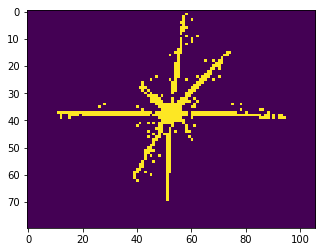

In [28]:
regionmax = getLargestRegion()
plt.imshow(np.where(labels == regionmax.label,1.0,0.0))
plt.show()

In [22]:


def getMinorMajorRatio(image):
    image = image.copy()
    # Create the thresholded image to eliminate some of the background
    imagethr = np.where(image > np.mean(image),0.,1.0)

    #Dilate the image
    imdilated = morphology.dilation(imagethr, np.ones((4,4)))

    # Create the label list
    label_list = measure.label(imdilated)
    label_list = imagethr*label_list
    label_list = label_list.astype(int)
    
    region_list = measure.regionprops(label_list)
    maxregion = getLargestRegion(region_list, label_list, imagethr)
    
    # guard against cases where the segmentation fails by providing zeros
    ratio = 0.0
    if ((not maxregion is None) and  (maxregion.major_axis_length != 0.0)):
        ratio = 0.0 if maxregion is None else  maxregion.minor_axis_length*1.0 / maxregion.major_axis_length
    return ratio

# Preprocessing

In [29]:
# read in data
train_df = pd.read_csv('./train_onelabel.csv')
train_images_paths = ['./train_images/' + p for p in train_df.image]
train_labels = train_df['class'].values

In [30]:
# create image matrix
train_images = (load_img(p, target_size=(32, 32)) for p in train_images_paths)
train_images = [img_to_array(img)[:, :, [0]] for img in train_images]
train_images = np.array(train_images)
train_images.shape

(24204, 32, 32, 1)

In [31]:
# preprocessing of labels
classes = len(np.unique(train_labels))
train_labels = to_categorical(train_labels, classes)

In [32]:
# split data into test and train set
x_train, y_train, x_val,  y_val = train_test_split(train_images, train_labels, test_size=0.2)

In [33]:
# normalize image data

x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x_train /= 255
y_train /= 255

# Model

In [34]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

In [35]:
# Initialising the CNN
classifier = Sequential()

In [36]:
# Step 1 - Convolution ---TODO: see input specification
classifier.add(Conv2D(64, (3, 3), input_shape = (32, 32,1),padding='same', activation = 'relu'))

In [37]:
# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

In [38]:
# Adding a second convolutional layer+pooling layer
classifier.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

In [39]:
# Step 3 - Flattening
classifier.add(Flatten())

In [40]:
#Step 4 - Create a fully connected neural network
'''its good practise to pick a number of power of two-experimenting output_dim
128 hidden nodes in hidden layers-by experimenting'''
 

#output_dim = number of nodes in the hidden layer
classifier.add(Dense(units= 256, activation = 'relu'))

#Dropout (p was used in the old API, changed it to the new standard)
classifier.add(Dropout(rate = 0.2))

#second hidden layer
classifier.add(Dense(units = 256, activation = 'relu'))

#Dropout
#classifier.add(Dropout(p = 0.2))

#output layer
classifier.add(Dense(units = 121, activation = 'softmax')) #We have 121 categories of plankton!!

In [41]:
# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [43]:
# fit model on training data
classifier.fit(x_train, x_val, batch_size=50, nb_epoch=20, verbose=1)

Epoch 1/20
19363/19363 [==============================] - 254s 13ms/step - loss: 3.3959 - acc: 0.2029
Epoch 2/20
19363/19363 [==============================] - 253s 13ms/step - loss: 2.3813 - acc: 0.3632
Epoch 3/20
19363/19363 [==============================] - 288s 15ms/step - loss: 2.0910 - acc: 0.4216
Epoch 4/20
19363/19363 [==============================] - 264s 14ms/step - loss: 1.9186 - acc: 0.4544
Epoch 5/20
19363/19363 [==============================] - 230s 12ms/step - loss: 1.7954 - acc: 0.4809
Epoch 6/20
19363/19363 [==============================] - 258s 13ms/step - loss: 1.6877 - acc: 0.5128
Epoch 7/20
19363/19363 [==============================] - 265s 14ms/step - loss: 1.6065 - acc: 0.5267
Epoch 8/20
12400/19363 [==================>...........] - ETA: 1:38 - loss: 1.5087 - acc: 0.5504

KeyboardInterrupt: 

In [ ]:
score = classifier.evaluate(y_train, y_val, verbose=0)
print(score)

# Save Model

In [ ]:
from keras.models import model_from_json

# serialize model to JSON
best_model_classification_json = classifier.to_json()
with open("best_model_3.json", "w") as json_file:
    json_file.write(best_model_classification_json)
# serialize weights to HDF5
classifier.save_weights("model_best.h5")
print("Saved model to disk")

# Load Model

In [ ]:
from keras.models import model_from_json

# load json and create model
json_file = open('best_model_3.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
classifier = model_from_json(loaded_model_json)
# load weights into new model
classifier.load_weights("model_best.h5")
print("Loaded model from disk")

# Prediction

In [ ]:
# read in data
test_df = pd.read_csv('./sample.csv')
test_images_paths = ['./test_images/' + p for p in test_df['image']]
test_images_names = [p for p in test_df['image']]

In [ ]:
# create image matrix
test_images = (load_img(p, target_size=(32, 32)) for p in test_images_paths)
test_images = [img_to_array(img)[:, :, [0]] for img in test_images]
test_images = np.array(test_images)
test_images.shape

In [ ]:
# normalize image data
test_images = test_images.astype('float32')
test_images /= 255

In [ ]:
result = classifier.predict(test_images)

In [ ]:
labels = []

for count, i in enumerate(result):
    labels.append(np.argmax(result[count]))

# Save results

In [ ]:
from collections import OrderedDict

#Create Final csv for the competition
csv_list =  pd.DataFrame( OrderedDict( { 'image': pd.Series(test_images_names), 'class': pd.Series(labels) } ) )
csv_list.to_csv('sample1.csv',index=False)

In [ ]:
results1 = pd.read_csv('./sample1.csv')